#### Bibliotecas

In [86]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.features import shapes
from shapely.geometry import shape
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import os
import re
import zipfile
import shutil
import rasterio
from rasterio.transform import from_origin
from rasterio.crs import CRS
import rasterio.features

#### Parâmetros

In [67]:
subprefeituras_shp = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_subprefeitura/SIRGAS_SHP_subprefeitura_polygon.shp'
raster_file = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/9_Dissertação/Resultados/Pacote_01/Raw/pct1_h_max_2768400.tif'
threshold = 0.3

#### Execução

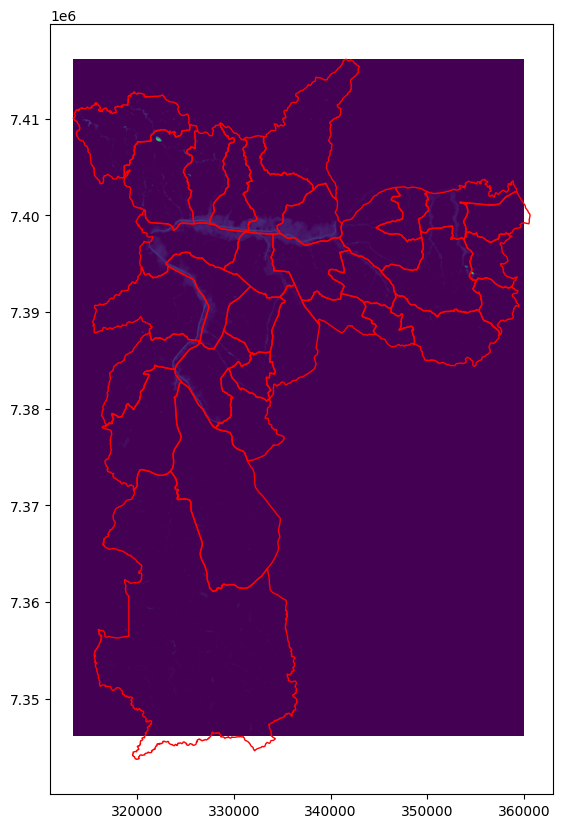

In [68]:
# Carregar o shapefile
gdf = gpd.read_file(subprefeituras_shp)

# Abrir o arquivo raster
raster_path = raster_file
raster = rasterio.open(raster_path)

# Criar a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o raster
show(raster, ax=ax)

# Plotar o shapefile por cima
gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)

# Exibir o mapa
plt.show()

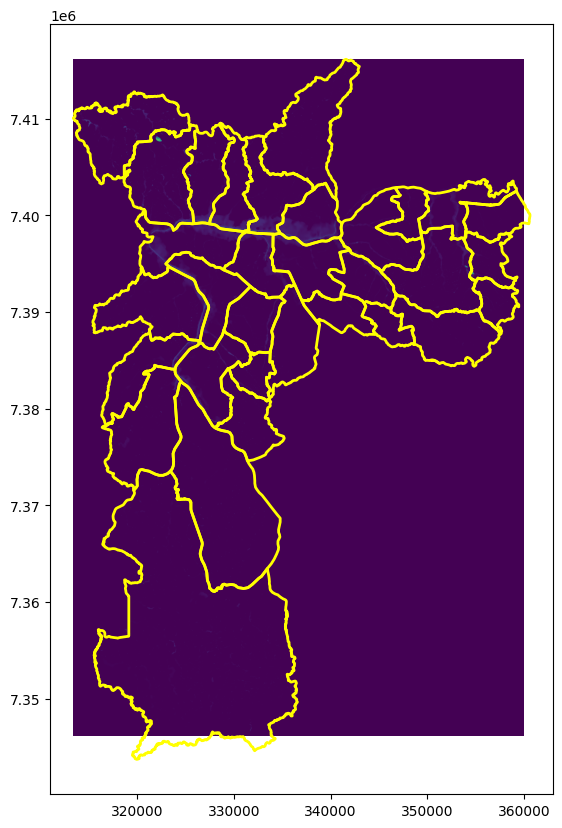

In [69]:
# Carregar o shapefile
gdf = gpd.read_file(subprefeituras_shp)

# Abrir o arquivo raster
raster_path = raster_file
with rasterio.open(raster_path) as raster:
    raster_data = raster.read(1).astype(float)  # Garantir que seja um array NumPy
    transform = raster.transform
    raster_crs = raster.crs  # Salvar o CRS antes de fechar
    
    # Criar máscara para valores > 7 cm
    mask = raster_data > threshold
    
    # Converter a máscara para vetores (polígonos)
    shapes_gen = shapes(raster_data, mask=mask, transform=transform)
    polygons = [shape(geom) for geom, value in shapes_gen if value]
    
# Criar GeoDataFrame com os polígonos detectados
high_values_gdf = gpd.GeoDataFrame(geometry=polygons, crs=raster.crs)
    
# Interseccionar com as subprefeituras
highlighted_subs = gdf[gdf.intersects(high_values_gdf.union_all())]

# Criar a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o raster
tmp_raster = rasterio.open(raster_path)  # Reabrir o raster
show(tmp_raster.read(1), transform=tmp_raster.transform, ax=ax)
tmp_raster.close()

# Plotar o shapefile por cima
gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)

# Destacar as subprefeituras afetadas
highlighted_subs.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=2)

# Exibir o mapa
plt.show()

In [70]:
# Contar pixels por subprefeitura e calcular percentual acima do threshold
results = []
with rasterio.open(raster_path) as raster:
    for _, subpref in gdf.iterrows():
        mask = rasterio.features.geometry_mask([subpref.geometry], transform=raster.transform, invert=True, out_shape=raster.shape)
        total_pixels = np.sum(mask)
        exceed_pixels = np.sum((raster_data > threshold) & mask)
        exceed_percentage = round((exceed_pixels / total_pixels) * 100, 2) if total_pixels > 0 else 0
        results.append([subpref["sp_nome"], total_pixels, exceed_pixels, exceed_percentage])

# Criar DataFrame de resultados
results_df = pd.DataFrame(results, columns=["Subprefeitura", "Total Pixels", "Exceed Pixels", "Exceeding Threshold"])

# Ordenar pelo percentual de pixels que excedem o threshold
results_df = results_df.sort_values(by="Exceeding Threshold", ascending=False)
results_df

Subprefeitura  Total Pixels  Exceed Pixels  \
8   VILA MARIA-VILA GUILHERME         31632          14530   
2                        LAPA         47796          16895   
4                          SE         31366           8845   
6                   PINHEIROS         37622          10510   
5            SANTANA-TUCURUVI         42071           8440   
14                 SAO MIGUEL         30739           6158   
9                       MOOCA         42381           8222   
1     CASA VERDE-CACHOEIRINHA         32033           6205   
25                SANTO AMARO         44374           8319   
16  ARICANDUVA-FORMOSA-CARRAO         26273           3880   
0       FREGUESIA-BRASILANDIA         37620           5393   
30           PIRITUBA-JARAGUA         64692           8911   
29                    BUTANTA         66227           8995   
15                   ITAQUERA         64823           8392   
24                  JABAQUARA         16478           1990   
21                CAMPO LIMPO         43156           5024   
12                      PENHA         47561           5204   
11               VILA MARIANA         31729           3357   
13         ERMELINO MATARAZZO         18751           1938   
3                       PERUS         66932           4847   
27                 GUAIANASES         20905           1343   
20                PARELHEIROS        411658          22440   
28          CIDADE TIRADENTES         17576            920   
31                M BOI MIRIM         73387           3724   
18              VILA PRUDENTE         22573           1080   
10                   IPIRANGA         44084           1936   
26             ITAIM PAULISTA         24316           1063   
19                  SAPOPEMBA         16035            583   
17                 SAO MATEUS         53279           1634   
23              CIDADE ADEMAR         36245           1107   
7             JACANA-TREMEMBE         76561           2294   
22          CAPELA DO SOCORRO        156219           4595   

    Exceeding Threshold  
8                 45.93  
2                 35.35  
4                 28.20  
6                 27.94  
5                 20.06  
14                20.03  
9                 19.40  
1                 19.37  
25                18.75  
16                14.77  
0                 14.34  
30                13.77  
29                13.58  
15                12.95  
24                12.08  
21                11.64  
12                10.94  
11                10.58  
13                10.34  
3                  7.24  
27                 6.42  
20                 5.45  
28                 5.23  
31                 5.07  
18                 4.78  
10                 4.39  
26                 4.37  
19                 3.64  
17                 3.07  
23                 3.05  
7                  3.00  
22                 2.94

In [ ]:
#TODO Pegar os Top10 da média de todos os pacotes

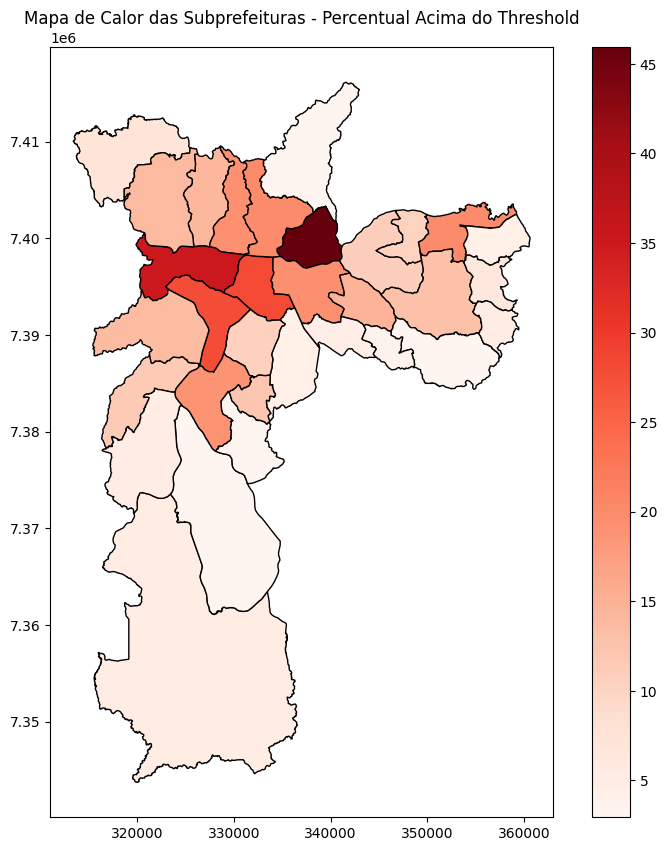

In [71]:
# Remover colunas duplicadas antes do merge
cols_to_drop = ["Subprefeitura", "Total Pixels", "Exceed Pixels", "% Exceeding Threshold"]
gdf = gdf.drop(columns=[col for col in cols_to_drop if col in gdf.columns], errors="ignore")

# Mesclar os resultados ao GeoDataFrame
gdf = gdf.merge(results_df, left_on="sp_nome", right_on="Subprefeitura", how="left", suffixes=("", "_dup"))

# Remover colunas duplicadas resultantes do merge
gdf = gdf.drop(columns=[col for col in gdf.columns if col.endswith("_dup")], errors="ignore")

# Criar colormap
norm = mcolors.Normalize(vmin=gdf["Exceeding Threshold"].min(), vmax=gdf["Exceeding Threshold"].max())
cmap = plt.colormaps.get_cmap("Reds")

# Criar mapa de calor
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column="Exceeding Threshold", cmap=cmap, edgecolor='black', linewidth=1, legend=True, norm=norm)
plt.title("Mapa de Calor das Subprefeituras - Percentual Acima do Threshold")
plt.show()



In [73]:
# Mesclar os resultados ao GeoDataFrame com sufixos para evitar colunas duplicadas
gdf = gdf.merge(results_df, left_on="sp_nome", right_on="Subprefeitura", how="left", suffixes=("", "_dup"))

# Remover colunas duplicadas desnecessárias
gdf = gdf.loc[:, ~gdf.columns.duplicated()]

# Carregar o shapefile e garantir que tenha um CRS definido
if gdf.crs is None:
    gdf.set_crs(epsg=31983, inplace=True)  # Definir CRS padrão (WGS 84) caso esteja indefinido

# Converter para CRS 31983 (SIRGAS 2000 / UTM zone 23S)
#gdf = gdf.to_crs(epsg=4326)

# Criar mapa interativo com .explore()
mapa = gdf.explore(
    column="Exceeding Threshold",  # Coluna para colorir o mapa
    cmap="Reds",  # Mapa de cores
    legend=True,  # Exibir legenda
    edgecolor="black",
    tooltip=["sp_nome","Exceeding Threshold"],  # Informações ao passar o mouse
    #tooltip=["sp_nome", "Exceeding Threshold"],  # Informações ao passar o mouse
    popup=True  # Exibir popup com detalhes ao clicar
)

# Exibir o mapa
mapa


#### Organizar os pacotes de arquivos

In [78]:
def organizar_pacotes(diretorio):
    # Expressão regular para identificar arquivos do tipo pctX... ou pctXX...
    padrao = re.compile(r'^pct(\d{1,2}).*\.zip$', re.IGNORECASE)
    
    # Lista os arquivos do diretório
    arquivos = [f for f in os.listdir(diretorio) if padrao.match(f)]
    
    for arquivo in arquivos:
        match = padrao.match(arquivo)
        if match:
            numero_pacote = match.group(1).zfill(2)  # Captura X ou XX e formata para dois dígitos
            pasta_pacote = os.path.join(diretorio, f'Pacote_{numero_pacote}')
            pasta_simulacao = os.path.join(pasta_pacote, 'Simulação')
            pasta_raw = os.path.join(pasta_pacote, 'RAW')
            
            # Criar diretórios se não existirem
            os.makedirs(pasta_simulacao, exist_ok=True)
            os.makedirs(pasta_raw, exist_ok=True)
            
            # Mover arquivo original para a pasta RAW
            origem = os.path.join(diretorio, arquivo)
            destino_raw = os.path.join(pasta_raw, arquivo)
            shutil.move(origem, destino_raw)
            
            # Extrair conteúdo na pasta Simulação
            with zipfile.ZipFile(destino_raw, 'r') as zip_ref:
                zip_ref.extractall(pasta_simulacao)
            
            print(f'Arquivo {arquivo} processado e armazenado em {pasta_pacote}')

In [79]:

diretorio_base = '/Volumes/MiniArmstro/Resultados'
organizar_pacotes(diretorio_base)

Arquivo pct1_h_files.zip processado e armazenado em /Volumes/MiniArmstro/Resultados/Pacote_01
Arquivo pct2_h_files.zip processado e armazenado em /Volumes/MiniArmstro/Resultados/Pacote_02
Arquivo pct3_h_files.zip processado e armazenado em /Volumes/MiniArmstro/Resultados/Pacote_03
Arquivo pct4_h_files.zip processado e armazenado em /Volumes/MiniArmstro/Resultados/Pacote_04
Arquivo pct5_h_files.zip processado e armazenado em /Volumes/MiniArmstro/Resultados/Pacote_05
Arquivo pct6_h_files.zip processado e armazenado em /Volumes/MiniArmstro/Resultados/Pacote_06
Arquivo pct7_h_files.zip processado e armazenado em /Volumes/MiniArmstro/Resultados/Pacote_07
Arquivo pct8_h_files.zip processado e armazenado em /Volumes/MiniArmstro/Resultados/Pacote_08
Arquivo pct9_h_files.zip processado e armazenado em /Volumes/MiniArmstro/Resultados/Pacote_09


#### Produzir os TIFs

In [84]:
def processar_arquivos_tif(diretorio_base):
    # Regex para identificar números em notação científica
    scientific_notation_pattern = re.compile(r'(-?\d+\.\d+e[+-]?\d+)')
    
    # Função para converter notação científica para número inteiro
    def convert_scientific_to_float(match):
        return f"{float(match.group()):.0f}"
    
    print("Iniciando o processamento dos arquivos '.tif'...")
    
    # Percorrer todas as pastas de simulação
    for pacote in os.listdir(diretorio_base):
        pasta_pacote = os.path.join(diretorio_base, pacote)
        pasta_simulacao = os.path.join(pasta_pacote, 'Simulação')
        
        if os.path.isdir(pasta_simulacao):
            tif_files = [file for file in os.listdir(pasta_simulacao) if file.endswith('.tif')]
            
            for filename in tif_files:
                print(f"Processando arquivo: {filename}")
                
                # Verificar e converter o nome do arquivo
                new_filename = scientific_notation_pattern.sub(convert_scientific_to_float, filename)
                
                # Caminhos completos do arquivo de origem e destino
                src = os.path.join(pasta_simulacao, filename)
                dst = os.path.join(pasta_simulacao, new_filename)
                
                try:
                    # Renomear o arquivo
                    os.rename(src, dst)
                    print(f"Arquivo '{filename}' renomeado para '{new_filename}'.")
                except Exception as e:
                    print(f"Erro ao processar '{filename}' em {pasta_simulacao}: {e}")
    
    print("Processamento dos arquivos '.tif' concluído.")
    print("Todos os arquivos foram processados com sucesso.")

In [85]:
processar_arquivos_tif(diretorio_base)


Iniciando o processamento dos arquivos '.tif'...
Processando arquivo: pct2_h_2.8296e+06.tif
Arquivo 'pct2_h_2.8296e+06.tif' renomeado para 'pct2_h_2829600.tif'.
Processando arquivo: ._pct2_h_2.8296e+06.tif
Erro ao processar '._pct2_h_2.8296e+06.tif' em /Volumes/MiniArmstro/Resultados/Pacote_02/Simulação: [Errno 2] No such file or directory: '/Volumes/MiniArmstro/Resultados/Pacote_02/Simulação/._pct2_h_2.8296e+06.tif' -> '/Volumes/MiniArmstro/Resultados/Pacote_02/Simulação/._pct2_h_2829600.tif'
Processando arquivo: pct2_h_2.826e+06.tif
Arquivo 'pct2_h_2.826e+06.tif' renomeado para 'pct2_h_2826000.tif'.
Processando arquivo: ._pct2_h_2.826e+06.tif
Erro ao processar '._pct2_h_2.826e+06.tif' em /Volumes/MiniArmstro/Resultados/Pacote_02/Simulação: [Errno 2] No such file or directory: '/Volumes/MiniArmstro/Resultados/Pacote_02/Simulação/._pct2_h_2.826e+06.tif' -> '/Volumes/MiniArmstro/Resultados/Pacote_02/Simulação/._pct2_h_2826000.tif'
Processando arquivo: pct2_h_2.7936e+06.tif
Arquivo 'pct2

In [82]:
def converter_asc_para_geotiff(diretorio_base):
    # Parâmetros do CRS e transformações
    target_epsg_code = 31983
    target_crs = CRS.from_epsg(target_epsg_code)
    xmin, ymin, xmax, ymax = (313394.4779, 7343769.0758, 360591.7331, 7416126.9551)
    res = 29.1591
    transform = from_origin(xmin, ymax, res, res)
    
    # Configurações para GeoTIFF
    geo_tiff_config = {
        "driver": "GTiff",
        "count": 1,  # Número de bandas
        "dtype": 'float32',  # Tipo de dados
        "crs": target_crs,
        "transform": transform,
    }
    
    print("Iniciando a conversão dos arquivos .asc para GeoTIFF...")
    
    # Percorrer todas as pastas de simulação
    for pacote in os.listdir(diretorio_base):
        pasta_pacote = os.path.join(diretorio_base, pacote)
        pasta_simulacao = os.path.join(pasta_pacote, 'Simulação')
        
        if os.path.isdir(pasta_simulacao):
            asc_files = [file for file in os.listdir(pasta_simulacao) if file.endswith('.asc')]
            
            for asc_name in asc_files:
                asc_path = os.path.join(pasta_simulacao, asc_name)
                output_name = f"{os.path.splitext(asc_name)[0]}.tif"
                output_path = os.path.join(pasta_simulacao, output_name)
                
                try:
                    # Carregar os dados do arquivo .asc
                    data = np.loadtxt(asc_path, skiprows=6)  # Ajuste skiprows conforme necessário
                    data = np.maximum(data, 0)  # Substituir valores negativos por 0
                    
                    # Atualizar altura e largura no GeoTIFF config
                    geo_tiff_config.update({"height": data.shape[0], "width": data.shape[1]})
                    
                    # Criar o GeoTIFF
                    with rasterio.open(output_path, 'w', **geo_tiff_config) as dst:
                        dst.write(data, 1)
                    
                    print(f"Arquivo convertido: {asc_name} -> {output_name}")
                    
                    # Apagar o arquivo original
                    os.remove(asc_path)
                    print(f"Arquivo original '{asc_name}' removido com sucesso.")
                    
                except Exception as e:
                    print(f"Erro ao processar o arquivo {asc_name} em {pasta_simulacao}: {e}")
    
    print("Conversão concluída com sucesso.")

In [83]:
converter_asc_para_geotiff(diretorio_base)

Iniciando a conversão dos arquivos .asc para GeoTIFF...
Arquivo convertido: pct2_h_2.844e+06.asc -> pct2_h_2.844e+06.tif
Arquivo original 'pct2_h_2.844e+06.asc' removido com sucesso.
Erro ao processar o arquivo ._pct2_h_2.844e+06.asc em /Volumes/MiniArmstro/Resultados/Pacote_02/Simulação: /Volumes/MiniArmstro/Resultados/Pacote_02/Simulação/._pct2_h_2.844e+06.asc not found.
Arquivo convertido: pct2_h_2.8296e+06.asc -> pct2_h_2.8296e+06.tif
Arquivo original 'pct2_h_2.8296e+06.asc' removido com sucesso.
Erro ao processar o arquivo ._pct2_h_2.8296e+06.asc em /Volumes/MiniArmstro/Resultados/Pacote_02/Simulação: /Volumes/MiniArmstro/Resultados/Pacote_02/Simulação/._pct2_h_2.8296e+06.asc not found.
Arquivo convertido: pct2_h_2.826e+06.asc -> pct2_h_2.826e+06.tif
Arquivo original 'pct2_h_2.826e+06.asc' removido com sucesso.
Erro ao processar o arquivo ._pct2_h_2.826e+06.asc em /Volumes/MiniArmstro/Resultados/Pacote_02/Simulação: /Volumes/MiniArmstro/Resultados/Pacote_02/Simulação/._pct2_h_2.82

#### Coletar as estatísticas

In [92]:
def processar_arquivos_tif(diretorio_base, gdf, threshold):
    resultados = {}

    print("🔍 Iniciando o processamento dos arquivos .tif...\n")

    # Percorre todas as pastas Pacote_X/Simulação
    for pacote in sorted(os.listdir(diretorio_base)):
        pasta_pacote = os.path.join(diretorio_base, pacote)
        pasta_simulacao = os.path.join(pasta_pacote, 'Simulação')

        if not os.path.isdir(pasta_simulacao):
            continue  # Pula se não for uma pasta válida

        print(f"📂 Processando pacote: {pacote}")

        # Listar arquivos .tif e remover arquivos ocultos "._*"
        tif_files = [f for f in os.listdir(pasta_simulacao) if f.endswith('.tif') and not f.startswith("._")]

        # Filtrar arquivo que contém "max" no nome
        max_files = [f for f in tif_files if "max" in f.lower()]
        if not max_files:
            print(f"⚠ Nenhum arquivo 'max' encontrado em {pasta_simulacao}. Pulando...\n")
            continue
        
        max_file = max_files[0]  # Pega o primeiro encontrado
        raster_path = os.path.join(pasta_simulacao, max_file)
        nome_coluna = os.path.splitext(max_file)[0]  # Nome do arquivo sem extensão

        print(f"🖼 Abrindo raster: {max_file}")

        results = []
        try:
            with rasterio.open(raster_path) as raster:
                raster_data = raster.read(1)  # Lê a banda 1 do raster

                for _, subpref in gdf.iterrows():
                    mask = rasterio.features.geometry_mask(
                        [subpref.geometry], transform=raster.transform, invert=True, out_shape=raster.shape
                    )
                    total_pixels = np.sum(mask)
                    exceed_pixels = np.sum((raster_data > threshold) & mask)
                    exceed_percentage = round((exceed_pixels / total_pixels) * 100, 2) if total_pixels > 0 else 0

                    results.append(exceed_percentage)

                    # Exibe progresso para cada subprefeitura
                    print(f"✅ {subpref['sp_nome']}: {exceed_percentage}% acima do threshold.")

            resultados[nome_coluna] = results
            print(f"✔ Processamento concluído para {max_file}\n")

        except Exception as e:
            print(f"❌ Erro ao processar {max_file}: {e}\n")

    # Criar DataFrame com os resultados
    resultados_df = pd.DataFrame(resultados, index=gdf["sp_nome"])
    print("🎯 Processamento finalizado! Resultados armazenados.\n")

    return resultados_df

In [93]:

resultados_df = processar_arquivos_tif(diretorio_base, gdf, threshold)
resultados_df

🔍 Iniciando o processamento dos arquivos .tif...

📂 Processando pacote: Pacote_01
🖼 Abrindo raster: pct1_h_max_2768400.tif
✅ FREGUESIA-BRASILANDIA: 14.34% acima do threshold.
✅ CASA VERDE-CACHOEIRINHA: 19.37% acima do threshold.
✅ LAPA: 35.35% acima do threshold.
✅ PERUS: 7.24% acima do threshold.
✅ SE: 28.2% acima do threshold.
✅ SANTANA-TUCURUVI: 20.06% acima do threshold.
✅ PINHEIROS: 27.94% acima do threshold.
✅ JACANA-TREMEMBE: 3.0% acima do threshold.
✅ VILA MARIA-VILA GUILHERME: 45.93% acima do threshold.
✅ MOOCA: 19.4% acima do threshold.
✅ IPIRANGA: 4.39% acima do threshold.
✅ VILA MARIANA: 10.58% acima do threshold.
✅ PENHA: 10.94% acima do threshold.
✅ ERMELINO MATARAZZO: 10.34% acima do threshold.
✅ SAO MIGUEL: 20.03% acima do threshold.
✅ ITAQUERA: 12.95% acima do threshold.
✅ ARICANDUVA-FORMOSA-CARRAO: 14.77% acima do threshold.
✅ SAO MATEUS: 3.07% acima do threshold.
✅ VILA PRUDENTE: 4.78% acima do threshold.
✅ SAPOPEMBA: 3.64% acima do threshold.
✅ PARELHEIROS: 5.45% ac

pct1_h_max_2768400  pct2_h_max_2851200  \
sp_nome                                                             
FREGUESIA-BRASILANDIA                   14.34               15.34   
CASA VERDE-CACHOEIRINHA                 19.37               20.48   
LAPA                                    35.35               36.03   
PERUS                                    7.24                7.70   
SE                                      28.20               28.85   
SANTANA-TUCURUVI                        20.06               20.86   
PINHEIROS                               27.94               28.65   
JACANA-TREMEMBE                          3.00                4.49   
VILA MARIA-VILA GUILHERME               45.93               46.48   
MOOCA                                   19.40               19.77   
IPIRANGA                                 4.39                4.24   
VILA MARIANA                            10.58               10.62   
PENHA                                   10.94               11.07   
ERMELINO MATARAZZO                      10.34               10.61   
SAO MIGUEL                              20.03               20.42   
ITAQUERA                                12.95               13.43   
ARICANDUVA-FORMOSA-CARRAO               14.77               15.14   
SAO MATEUS                               3.07                3.55   
VILA PRUDENTE                            4.78                4.85   
SAPOPEMBA                                3.64                3.87   
PARELHEIROS                              5.45                6.50   
CAMPO LIMPO                             11.64               11.76   
CAPELA DO SOCORRO                        2.94                3.58   
CIDADE ADEMAR                            3.05                3.11   
JABAQUARA                               12.08               12.27   
SANTO AMARO                             18.75               19.25   
ITAIM PAULISTA                           4.37                4.52   
GUAIANASES                               6.42                6.53   
CIDADE TIRADENTES                        5.23                5.37   
BUTANTA                                 13.58               14.31   
PIRITUBA-JARAGUA                        13.77               14.10   
M BOI MIRIM                              5.07                5.17   

                           pct3_h_max_2937600  pct4_h_max_3024000  \
sp_nome                                                             
FREGUESIA-BRASILANDIA                   15.55               15.46   
CASA VERDE-CACHOEIRINHA                 20.79               20.78   
LAPA                                    36.36               36.19   
PERUS                                    8.17                8.35   
SE                                      28.89               28.88   
SANTANA-TUCURUVI                        21.08               21.19   
PINHEIROS                               28.62               28.25   
JACANA-TREMEMBE                          5.34                5.95   
VILA MARIA-VILA GUILHERME               46.30               46.10   
MOOCA                                   19.54               19.55   
IPIRANGA                                 4.28                4.38   
VILA MARIANA                            10.57               10.50   
PENHA                                   10.88               11.25   
ERMELINO MATARAZZO                      10.30               10.15   
SAO MIGUEL                              20.32               20.12   
ITAQUERA                                13.42               13.46   
ARICANDUVA-FORMOSA-CARRAO               15.10               15.30   
SAO MATEUS                               4.09                4.26   
VILA PRUDENTE                            5.11                5.50   
SAPOPEMBA                                3.95                3.99   
PARELHEIROS                              9.41               10.73   
CAMPO LIMPO                             12.90               12.48   
CAPELA DO SOCORRO       

In [94]:
# Calcular média e desvio padrão
resultados_df["Média"] = resultados_df.mean(axis=1).round(2)
resultados_df["Desvio_Padrão"] = resultados_df.std(axis=1, ddof=0).round(2)

# Criar DataFrame final ordenado pela média (descrescente)
resultados_finais = resultados_df[["Média", "Desvio_Padrão"]].reset_index()
resultados_finais = resultados_finais.rename(columns={"index": "Subprefeitura"})
resultados_finais = resultados_finais.sort_values(by="Média", ascending=False)
resultados_finais

sp_nome  Média  Desvio_Padrão
8   VILA MARIA-VILA GUILHERME  43.83           2.70
2                        LAPA  32.22           4.20
4                          SE  26.85           2.14
6                   PINHEIROS  26.35           2.06
14                 SAO MIGUEL  19.25           2.07
5            SANTANA-TUCURUVI  18.43           2.13
1     CASA VERDE-CACHOEIRINHA  18.04           1.84
9                       MOOCA  17.88           1.59
25                SANTO AMARO  15.54           3.66
16  ARICANDUVA-FORMOSA-CARRAO  14.20           0.70
0       FREGUESIA-BRASILANDIA  13.41           1.15
30           PIRITUBA-JARAGUA  13.28           0.71
29                    BUTANTA  12.86           1.39
24                  JABAQUARA  11.91           0.35
15                   ITAQUERA  11.90           2.47
21                CAMPO LIMPO  10.67           1.53
12                      PENHA  10.52           0.58
11               VILA MARIANA  10.20           0.53
13         ERMELINO MATARAZZO  10.09           0.47
3                       PERUS   6.47           1.15
27                 GUAIANASES   6.03           1.32
20                PARELHEIROS   5.23           2.24
28          CIDADE TIRADENTES   4.86           1.07
31                M BOI MIRIM   4.55           0.99
18              VILA PRUDENTE   4.00           0.70
10                   IPIRANGA   3.98           0.50
26             ITAIM PAULISTA   3.87           0.84
22          CAPELA DO SOCORRO   3.18           0.88
19                  SAPOPEMBA   3.16           0.72
7             JACANA-TREMEMBE   2.86           1.25
23              CIDADE ADEMAR   2.83           0.49
17                 SAO MATEUS   2.34           1.49